# Changing your face with StyleGAN2 with face of your favorite personality
* For video visit visit the [Results](https://youtu.be/qFc91S3OPIE).

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


# Part 9.4: Transfer Learning for Facial Points and GANs

I designed this notebook to work with Google Colab. You can run it locally; however, you might need to adjust some of the installation scripts contained in this notebook.

In this part, we will see how we can use a 3rd party neural network to detect facial features, particularly the location of an individual's eyes. By locating eyes, we can crop portraits consistently. Previously, we saw that GANs could convert a random vector into a realistic-looking portrait. We can also perform the reverse and convert an actual photograph into a numeric vector. If we convert two images into these vectors, we can produce a video that transforms between the two images. 

NVIDIA trained StyleGAN on portraits consistently cropped with the eyes always in the same location. To successfully convert an image to a vector, the image must be copped similarly to NVIDIA. 

The code presented here allows you to choose a starting and ending image and use StyleGAN2 to produce a "morph" video between the two pictures. The preprocessing code will lock in on the exact positioning of each image, so your crop does not have to be perfect. The main point of your crop is for you to remove anything else that might be confused for a face. If multiple faces are detected, you will receive an error.

Also, make sure you have selected a GPU Runtime from CoLab. Choose "Runtime," then "Change Runtime Type," and choose GPU for "Hardware Accelerator."

These settings allow you to change the high-level configuration. The number of steps determines how long your resulting video is. The video plays at 30 frames a second, so 150 is 5 seconds. You can also specify freeze steps to leave the video unchanged at the beginning and end. You will not likely need to change the network.


In [2]:
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

### Upload Starting and Ending Images

We will begin by uploading a starting and ending image. The Colab service uploads these images. If you are running this code outside of Colab, these images are likely somewhere on your computer, and you provide the path to these files using the SOURCE and TARGET variables.

Choose your starting image.

In [3]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving maya02.jpg to maya02.jpg


Also, choose your ending image.

In [4]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving scarlett-01.jpg to scarlett-01.jpg


# Install Software

Some software must be installed into Colab, for this notebook to work. We are specificially using these technologies:

* [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
Tero Karras, Miika Aittala, Janne Hellsten, Samuli Laine, Jaakko Lehtinen, Timo Aila
* [One millisecond face alignment with an ensemble of regression trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf) Vahid Kazemi, Josephine Sullivan


In [5]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

--2022-03-21 12:42:38--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  7.20MB/s    in 0.8s    

2022-03-21 12:42:39 (7.20 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [6]:
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (57/57), done.
     |████████████████████████████████| 108 kB 10.3 MB/s 


### Detecting Facial Features

First, I will demonstrate how to detect the facial features we will use for consistent cropping and centering of the images. To accomplish this, we will use the [dlib](http://dlib.net/) package, a neural network library that gives us access to several pretrained models. The [DLIB Face Recognition ResNET Model V1](https://github.com/davisking/dlib-models) is the model we will use; This is a 5 point landmarking model which identifies the corners of the eyes and bottom of the nose. The creators of this network trained it on the dlib 5-point face landmark dataset, which consists of 7198 faces.

We begin by initializing dlib and loading the facial features neural network.

In [7]:
import cv2
import numpy as np
from PIL import Image
import dlib
from matplotlib import pyplot as plt

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

Let's start by looking at the facial features of the source image. The following code detects the five facial features and displays their coordinates.

In [8]:
img = cv2.imread(SOURCE_NAME)
if img is None:
    raise ValueError("Source image not found")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)

if len(rects) == 0:
  raise ValueError("No faces detected")
elif len(rects) > 1:
  raise ValueError("Multiple faces detected")

shape = predictor(gray, rects[0])

w = img.shape[0]//50

for i in range(0, 5):
  pt1 = (shape.part(i).x, shape.part(i).y)
  pt2 = (shape.part(i).x+w, shape.part(i).y+w)
  cv2.rectangle(img,pt1,pt2,(0,255,255),4)
  print(pt1,pt2)

(841, 614) (866, 639)
(737, 628) (762, 653)
(464, 621) (489, 646)
(573, 630) (598, 655)
(660, 844) (685, 869)


We can easily plot these features onto the source image. You can see the corners of the eyes and the base of the nose.

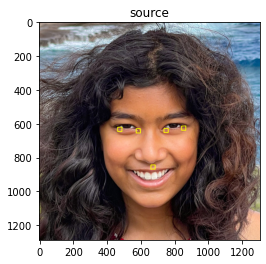

In [9]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

### Preprocess Images for Best StyleGAN Results

Using dlib, we will center and crop the source and target image, using the eye positions as reference. I created two functions to accomplish this task. The first calls dlib and find the locations of the person's eyes. The second uses the eye locations to center the image around the eyes. We do not exactly center; we are offsetting slightly to center similarly to the original StyleGAN training set. I determined this offset by detecting the eyes of a generated StyleGAN face. The distance between the eyes gives us a means of telling how big the face is, which we use to scale the images consistently.  

In [10]:
def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  # Calculate the size of the face
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  # Consider the aspect ratio
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  # Adjust to the offset used by StyleGAN2
  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

The following code will preprocess and crop your images.  If you receive an error indicating multiple faces were found, try to crop your image better or obscure the background.  If the program does not see a face, then attempt to obtain a clearer and more high-resolution image.

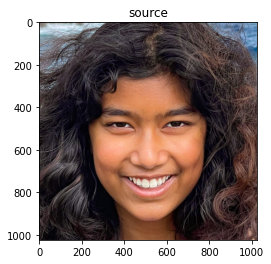

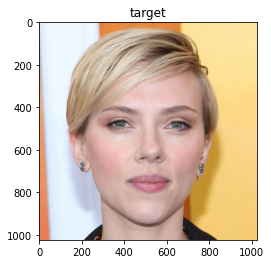

True

In [11]:
image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))

The two images are now 1024x1024 and cropped similarly to the ffhq dataset that NVIDIA used to train StyleGAN.

# Convert Source to a GAN

We will use StyleGAN2, rather than the latest StyleGAN3, because StyleGAN2 contains a projector.py utility that converts images to latent vectors. StyleGAN3 does not have as good of support of this [projection](https://github.com/NVlabs/stylegan3/issues/54). First, we convert the source to a GAN latent vector. This process will take several minutes.

In [12]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=cropped_source.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.67 loss 24567.22
step    2/1000: dist 0.58 loss 27640.48
step    3/1000: dist 0.55 loss 27166.93
step    4/1000: dist 0.61 loss 26253.10
step    5/1000: dist 0.55 loss 24956.85
step    6/1000: dist 0.62 loss 23353.76
step    7/1000: dist 0.62 loss 21512.52
step    8/1000: dist 0.59 loss 19485.90
step    9/1000: dist 0.61 loss 17339.20
step   10/1000: dist 0.58 loss 15139.45
step   11/1000: dist 0.57 loss 12948.98
step   12/1000: dist 0.64 loss 10818.45
step   13/1000: dist 0.58 loss 8801.99
step   14/1000: dist 0.53 loss 6945.88
step   15/1000: dist 0.54 loss 5315.19
step   16/1000: dist 0.51 loss 3970.82
step   17/1000: dist 0.53 loss 2943.95
step   18/1000: dist 0.52 loss 2215.08
step   19/1000: dist 0

# Convert Target to a GAN

Next, we convert the target to a GAN latent vector.  This process will also take several minutes.

In [13]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.63 loss 24567.18
step    2/1000: dist 0.66 loss 27640.55
step    3/1000: dist 0.63 loss 27167.01
step    4/1000: dist 0.65 loss 26253.15
step    5/1000: dist 0.63 loss 24956.92
step    6/1000: dist 0.57 loss 23353.71
step    7/1000: dist 0.65 loss 21512.56
step    8/1000: dist 0.61 loss 19485.92
step    9/1000: dist 0.68 loss 17339.27
step   10/1000: dist 0.65 loss 15139.51
step   11/1000: dist 0.58 loss 12948.99
step   12/1000: dist 0.52 loss 10818.32
step   13/1000: dist 0.65 loss 8802.06
step   14/1000: dist 0.55 loss 6945.89
step   15/1000: dist 0.51 loss 5315.16
step   16/1000: dist 0.52 loss 3970.82
step   17/1000: dist 0.55 loss 2943.97
step   18/1000: dist 0.48 loss 2215.04
step   19/1000: dist 0

With the conversion complete, lets have a look at the two GANs.

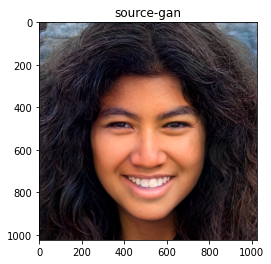

In [14]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

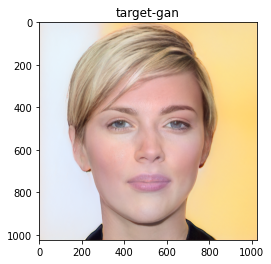

In [15]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

As you can see, the two GAN-generated images look similar to their real-world counterparts.

# Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [16]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
   
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [ ]:
from google.colab import files
files.download("movie.mp4") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>